#Sequence to Sequence:
입력된 sequence와 다른 sequence를 출력하는 분야에서 사용되는 모델이다. 입력 sequence를 질문, 출력 sequence를 대답으로 구성하거나 입력을 A 언어로 한다면 출력을 B 언어로 할 수 있기 때문에 챗봇이나 번역기를 만들 때 사용된다.



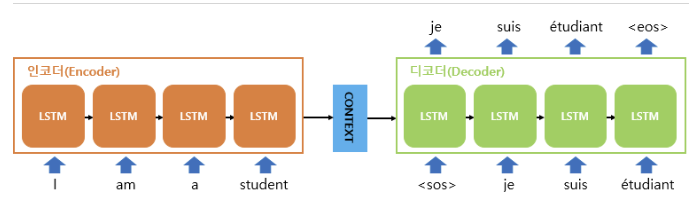

#Seq2Seq의 모델
모델은 크게 두 부분으로 구성된다. 첫 번째로 인코더는 입력 문장의 모든 단어들을 순차적으로(sequentially) 입력받아 모든 단어 정보들을 압축해서 하나의 벡터로 만든다. 이를 Context Vector라고 부른다. 이 벡터는 인코더의 RNN cell의 마지막 hidden state이다. 이 벡터를 디코더로 전송하면, 디코더는 이를 decode하여 출력값을 얻는 것이다.  

#훈련 단계와 테스트 단계

seq2seq는 훈련 과정과 테스트 과정에서 디코더가 입력받는 정보는 다르다.
훈련 과정에서는 Context Vector와 입력 문장의 번역 결과(<'sos'> je suis étudiant)을 입력받고 테스트 과정에서는 Context Vector만 입력받는다. 이러한 훈련 과정을 Teacher Forcing이라고 부른다.

#디코더의 분해

디코더에서 인코더의 마지막 hidden state을 입력받은 뒤, 각 RNN cell의 hidden state가 된 뒤, 이 값은 Neural Network인 Dense Layer를 거치게 된다. 이 layer는 vocabulary size 차원의 벡터로 바꾸어주어 hidden state값을 softmax를 쉽게 할 수 있도록 해주는 것이다. softmax 함수를 통해 이 값은 최종적으로 각 단어가 나올 확률값으로 변하게 되고 단어 예측값을 얻게 된다.

#Seq2Seq 번역기

#데이터 전처리
번역기를 훈련시키기 위해서는 parallel corpus가 필요하다. 이는 두 개 이상의 언어가 병렬적으로 구성된 데이터이다. 이 때 염두해야 하는 것은 두 데이터의 길이가 같지 않다는 것이다. 예를 들어, "I am a student"는 "나는 학생이다"와 token 수가 다르다.

In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import torch
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
!wget -c http://www.manythings.org/anki/fra-eng.zip && unzip -o fra-eng.zip

--2024-03-20 07:37:48--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  32.3MB/s    in 0.2s    

2024-03-20 07:37:48 (32.3 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


이 데이터는 다른 두 언어들이 tab으로 구분되어있다. 이를 분리하여 데이터셋으로 만들어야 한다.

In [ ]:
num_samples = 33000

#구두점 제거, 단어와 구분해주기 위한 전처리
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!='Mn')

def preprocess_sentence(sent):
  sent = unicode_to_ascii(sent.lower())
  sent = re.sub(r"([?.!,¿])", r" \1", sent) #단어와 구두점 사이에 공백 만들기
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent) #alphabet과 구두점을 빈칸으로 변환
  sent = re.sub(r"\s+", " ", sent) #빈칸 여러개 생긴 거 하나로 축약
  return sent

#병렬적으로 구성된 두 언어를 분리
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      src_line, target_line, _ = line.strip().split('\t')
      src_line = [w for w in preprocess_sentence(src_line).split()]

      target_line = preprocess_sentence(target_line)
      target_line_in = [w for w in ("<sos> " + target_line).split()]
      target_line_out = [w for w in (target_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(target_line_in)
      decoder_target.append(target_line_out)

      if i == num_samples-1:
        break
  return encoder_input, decoder_input, decoder_target


In [ ]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))


전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [ ]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()


Teacher Forcing을 이용할 것이기 때문에 이렇게 훈련할 때 사용할 디코더의 입력 sequence와 실제값을 분리하여 저장해야 한다. 또, 입력 sequence에서는 <'SOS'>를 넣고 실제값에는 <'EOS'>를 붙인다.

In [ ]:
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


#훈련 과정에서 디코더 입력으로 Context Vector뿐만 아니라 실제 정답도 사용하는 이유

RNN의 특징으로는 보통 이전 시점의 hidden state을 다음 시점의 입력값으로 사용하는데 디코더에서의 이전 hidden state, 즉 이전 시점의 예측값이 잘못된 예측이라면, 현재 시점의 예측값도 잘못될 수 있고 그 후에도 계속 영향을 줄 수 있다. 이를 막기 위해 실제값도 입력하여 성능을 향상시키는 것이다. 이런 방법을 **Teacher Forcing**이라고 한다.

#각 언어 데이터의 Vocab 만들기



vocab 내 index로 각 언어의 단어들을 encoding 하자

In [ ]:
def build_vocab(sents):
  word_list= []
  for sent in sents:
    for word in sent:
      word_list.append(word)

  word_counts = Counter(word_list)
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  word2index = {}
  word2index['<PAD>'] = 0
  word2index['<UNK>'] = 1

  for index, word in enumerate(vocab):
    word2index[word] = index+2

  return word2index

In [ ]:
src_vocab = build_vocab(sents_en_in)
tar_vocab = build_vocab(sents_fra_in + sents_fra_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)

print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4488, 프랑스어 단어 집합의 크기 : 7884


In [ ]:
#index로 인코딩된 단어들을 단어로 디코딩하는것
index2src = {v:k for k,v in src_vocab.items()}
index2tar = {v:k for k,v in tar_vocab.items()}

#text를 정수로 바꿔주는 것
def texts_to_sequences(sents, word2index):
  encoded_X_data = []
  for sent in tqdm(sents):
    index_sequences = []
    for word in sent:
      try:
        index_sequences.append(word2index[word])
      except KeyError:
        index_sequences.append(word2index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data


In [ ]:
encoder_input = texts_to_sequences(sents_en_in, src_vocab)
decoder_input = texts_to_sequences(sents_fra_in, tar_vocab)
decoder_target = texts_to_sequences(sents_fra_out, tar_vocab)


100%|██████████| 33000/33000 [00:00<00:00, 373730.01it/s]


In [ ]:
# 상위 5개의 샘플에 대해서 정수 인코딩 전, 후 문장 출력
# 인코더 입력이므로 <sos>나 <eos>가 없음
for i, (item1, item2) in zip(range(5), zip(sents_en_in, encoder_input)):
    print(f"Index: {i}, 정수 인코딩 전: {item1}, 정수 인코딩 후: {item2}")


Index: 0, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 1, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 2, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 3, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 4, 정수 인코딩 전: ['hi', '.'], 정수 인코딩 후: [742, 2]


#패딩

In [ ]:
def pad_sequences(sentences, max_len=None):
  if(max_len is None):
    max_len = max([len(sentence) for sentence in sentences])
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if(len(sentence)!=0):
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features


In [ ]:
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)


In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)


인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


#훈련 데이터, 검증 데이터, Test 데이터 분리

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)



In [ ]:
#데이터 순서 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [ ]:
test_num = int(encoder_input.shape[0]*0.1)
test_num


3300

In [ ]:
encoder_input_train = encoder_input[:-test_num]
decoder_input_train = decoder_input[:-test_num]
decoder_target_train = decoder_target[:-test_num]

encoder_input_test = encoder_input[-test_num:]
decoder_input_test = decoder_input[-test_num:]
decoder_target_test = decoder_target[-test_num:]


In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)


훈련 source 데이터의 크기 : (29700, 7)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 7)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


#기계 번역기 모델 구현

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 256
hidden_units = 256

In [ ]:
class Encoder(nn.Module):
  def __init__(self, src_vocab_size, embedding_dim, hidden_units):
    super(Encoder, self).__init__()
    self.embedding = nn.Embedding(src_vocab_size,embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)

  def forward(self, x):
    x = self.embedding(x)
    #Encoder의 출력값은 hidden state와 cell state만 있으면 된다
    _, (hidden, cell) = self.lstm(x)
    return hidden, cell

In [ ]:
class Decoder(nn.Module):
  def __init__(self, target_vocab_size, embedding_dim, hidden_units):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(target_vocab_size, embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first = True)
    self.fc = nn.Linear(hidden_units, target_vocab_size)
  def forward(self, x, hidden, cell):
    x = self.embedding(x)
    #encoder의 hidden, cell 값을 context vector로 입력받는 부분
    output, (hidden, cell) = self.lstm(x, (hidden, cell))
    output = self.fc(output)
    return output, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, src, target):
    hidden, cell = self.encoder(src)

    #훈련할 때는 디코더의 출력 중 output만 사용
    #decoder의 입력으로 encoder의 hidden과 cell state 그리고 정답값
    output, _, _ = self.decoder(target, hidden, cell)

    return output

In [ ]:
encoder = Encoder(src_vocab_size, embedding_dim, hidden_units)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_units)
model = Seq2Seq(encoder, decoder)

loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

In [ ]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4488, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7884, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7884, bias=True)
  )
)


검증, 훈련

In [ ]:
def evaluation(model, dataloader, loss_function, device):
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total_count = 0

  with torch.no_grad():
    for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
      encoder_inputs = encoder_inputs.to(device)
      decoder_inputs = decoder_inputs.to(device)
      decoder_targets = decoder_targets.to(device)

      outputs = model(encoder_inputs, decoder_inputs)

      loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
      total_loss +=loss.item()

      mask = decoder_targets != 0
      total_correct +=((outputs.argmax(dim=-1) == decoder_targets)*mask).sum().item()
      total_count +=mask.sum().item()
  return total_loss / len(dataloader), total_correct / total_count



In [ ]:
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype=torch.long)

encoder_input_test_tensor = torch.tensor(encoder_input_test, dtype=torch.long)
decoder_input_test_tensor = torch.tensor(decoder_input_test, dtype=torch.long)
decoder_target_test_tensor = torch.tensor(decoder_target_test, dtype=torch.long)

# 데이터셋 및 데이터로더 생성
batch_size = 128

train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(encoder_input_test_tensor, decoder_input_test_tensor, decoder_target_test_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 학습 설정
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4488, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7884, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7884, bias=True)
  )
)

In [ ]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # 훈련 모드
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순방향 전파
        # outputs.shape == (batch_size, seq_len, tar_vocab_size)
        outputs = model(encoder_inputs, decoder_inputs)

        # 손실 계산 및 역방향 전파
        # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
        # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
        loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

    train_loss, train_acc = evaluation(model, train_dataloader, loss_function, device)
    valid_loss, valid_acc = evaluation(model, valid_dataloader, loss_function, device)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if valid_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch: 1/30 | Train Loss: 3.0127 | Train Acc: 0.5192 | Valid Loss: 3.1219 | Valid Acc: 0.5137
Validation loss improved from inf to 3.1219. 체크포인트를 저장합니다.
Epoch: 2/30 | Train Loss: 2.3268 | Train Acc: 0.5969 | Valid Loss: 2.5565 | Valid Acc: 0.5851
Validation loss improved from 3.1219 to 2.5565. 체크포인트를 저장합니다.
Epoch: 3/30 | Train Loss: 1.9302 | Train Acc: 0.6401 | Valid Loss: 2.2687 | Valid Acc: 0.6167
Validation loss improved from 2.5565 to 2.2687. 체크포인트를 저장합니다.
Epoch: 4/30 | Train Loss: 1.6166 | Train Acc: 0.6718 | Valid Loss: 2.0738 | Valid Acc: 0.6382
Validation loss improved from 2.2687 to 2.0738. 체크포인트를 저장합니다.
Epoch: 5/30 | Train Loss: 1.3660 | Train Acc: 0.7087 | Valid Loss: 1.9289 | Valid Acc: 0.6565
Validation loss improved from 2.0738 to 1.9289. 체크포인트를 저장합니다.
Epoch: 6/30 | Train Loss: 1.1524 | Train Acc: 0.7425 | Valid Loss: 1.8189 | Valid Acc: 0.6737
Validation loss improved from 1.9289 to 1.8189. 체크포인트를 저장합니다.
Epoch: 7/30 | Train Loss: 0.9705 | Train Acc: 0.7801 | Valid Loss: 

In [43]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

model.to(device)

val_loss, val_accuracy = evaluation(model, valid_dataloader, loss_function, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 1.5373
Best model validation accuracy: 0.7181


#seq2seq 기계 번역기 동작

Test를 해보자.

In [44]:
#입력의 정수 sequence를 text로
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index2src[encoded_word]+ ' '
  return sentence

#번역(출력)의 정수 sequence를 text로
def seq_to_target(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word!=tar_vocab['<eos>']):
      sentence = sentence + index2tar[encoded_word]+ ' '
  return sentence


Seq2Seq는 Test에서 Decoder가 입력으로 받는 것이 다르기 때문에 Decoder를 다르게 정의해야 한다. Test에서는 정답을 입력받지 않고 encoder의 마지막 hidden과 cell state만 받기 때문이다.

In [48]:

def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
  encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

  #encoder의 hidden과 cell값
  hidden, cell = model.encoder(encoder_inputs)

  #<sos>를 처음에 넣기 위해 미리 처리
  decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(device)
  decoded_tokens= []

  for _ in range(max_output_len):
    #decoder rnn cell의 결과, encoder의 결과를 입력으로 계속 넣으며 작동
    output, hidden, cell=model.decoder(decoder_input, hidden, cell)
    #softmmax
    output_token = output.argmax(dim=-1).item()
    #<eos> 종료 토큰이라면
    if output_token ==4:
      break
    #결과 sequence에 넣기
    decoded_tokens.append(output_token)
    #다음 층의 입력으로 현재 시점 output 넣기
    decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(device)
  #최종 문장 출력
  return ' '.join(int_to_tar_token[token] for token in decoded_tokens)

In [55]:
for seq_index in [10, 30, 100, 300, 1000]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index2src, index2tar)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_target(decoder_input_test[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)


입력문장 : they are pilots . 
정답문장 : ils sont pilotes . 
번역문장 : ils sont pilotes .
--------------------------------------------------
입력문장 : i love you anyway . 
정답문장 : je vous aime quand meme . 
번역문장 : je t aime bien .
--------------------------------------------------
입력문장 : i want to talk . 
정답문장 : je veux discuter . 
번역문장 : je veux parler .
--------------------------------------------------
입력문장 : deal me out . 
정답문장 : ne compte pas sur moi . 
번역문장 : moi sortir !
--------------------------------------------------
입력문장 : don t tell anyone . 
정답문장 : ne le dites a personne ! 
번역문장 : ne le dis a personne !
--------------------------------------------------


#BLEU Score (Bilingual Evaluation Understudy Score)

기계 번역기를 평가할 때 사용하는 지표

기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법이다. 측정 기준은 n-gram에 기반한다.

n-gram 기반이기에 완벽한 방법은 아니지만 장점이 많다.

1. 언어에 구애받지 않고 사용할 수 있다.

2. 계산속도가 빠르다



# 번역 성능 측정하는 다른 방법들

1. Unigram Precision: 단어 개수 카운트로 측정하기

기계 번역기의 결과와 Reference를 비교하여 기계 번역기의 성능을 계산하는 것이다.

Ca를 기계 번역기의 결과, Ref를 실제 번역 결과(Reference)라고 한다면

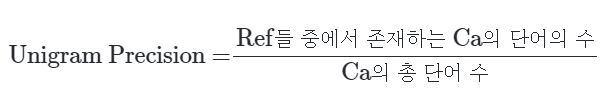

**Unigram Precision의 문제점**
기계 번역 결과에 특정 단어들이 많이 반복될 때, 문제점이 생긴다.



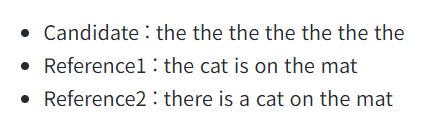

이 예시를 보면, 기계번역기의 결과인 Candidate는 성능이 엉망이지만, reference1와 reference2에 있는 단어로만 구성이 되어 Unigram Precision 값이 7/7 = 1이 된다.

이를 통해 분자의 계산 방법을 변형시켜야 함을 알 수 있다.

Candidate의 각 단어가 하나의 Reference에서 최대 몇번 등장했는지 카운트 한다. 이 값을 Max_Ref_Count로 정의하자. 이제 이 값을 기존의 분자와 비교하여 둘 중에 작은 값을 분자로 하는 것이다.



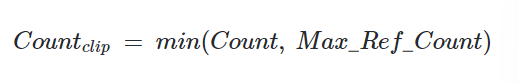

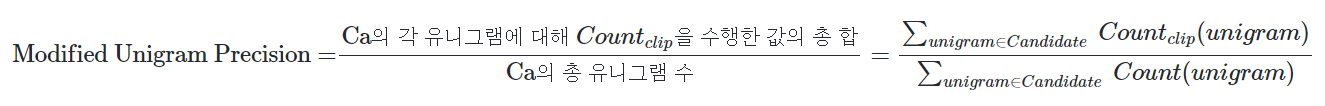

*Unigram의 문제점 개선 여부 확인*

Candidate의 The는 reference 1에서는 2번 나왔기 때문에 Count_clip의 값은 7이 아니라 2가 된다. -> **문제가 해결되었다.**

#Modified Unigram Precision 구현

기존의 Count와 Count_clip을 구하는 함수 두 개를 정의해보자

In [9]:
import numpy as np
from collections import Counter
from nltk import ngrams

In [12]:
#tokens에서 n-gram 카운트하기
def simple_count(tokens, n):
  return Counter(ngrams(tokens, n))

문제가 없는 상황

In [13]:
candidate = "It is a guide to action which ensures that the military always obeys the commands of the party."
tokens = candidate.split() # 토큰화
result = simple_count(tokens, 1) # n = 1은 유니그램
print('유니그램 카운트 :',result)

유니그램 카운트 : Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})


단순 Count 기반 문제점 상

In [14]:
candidate = 'the the the the the the the'
tokens = candidate.split() # 토큰화
result = simple_count(tokens, 1) # n = 1은 유니그램
print('유니그램 카운트 :',result)


유니그램 카운트 : Counter({('the',): 7})


In [15]:
#Count_Clip 코드
def count_clip(candidate, reference_list, n):
  #candidate의 ngram
  candidate_cnt = simple_count(candidate, n)
  #max_ref_cnt 값 저장하는 곳
  max_ref_cnt_dict = dict()

  for ref in reference_list:
    #reference의 ngram
    ref_cnt = simple_count(ref,n)
    for n_gram in ref_cnt:
      if(n_gram in max_ref_cnt_dict):
        max_ref_cnt_dict[n_gram] = max(ref_cnt[n_gram], max_ref_cnt_dict[n_gram])
      else:
        max_ref_cnt_dict[n_gram] = ref_cnt[n_gram]

  return {
      #count와 max_ref_count 비교해서 min값 저장
      n_gram: min(candidate_cnt.get(n_gram, 0), max_ref_cnt_dict.get(n_gram, 0)) for n_gram in candidate_cnt
  }


In [16]:
candidate = 'the the the the the the the'
references = [
    'the cat is on the mat',
    'there is a cat on the mat'
]
result = count_clip(candidate.split(),list(map(lambda ref: ref.split(), references)),1)
print('보정된 유니그램 카운트 :',result)


보정된 유니그램 카운트 : {('the',): 2}


In [11]:
#보정된 unigram precision 구하는 함수
def modified_precision(candidate, reference_list, n):
  clip_cnt = count_clip(candidate, reference_list, n)
  total_clip_cnt = sum(clip_cnt.values())

  cnt = simple_count(candidate, n)
  total_cnt = sum(cnt.values())

  if total_cnt==0:
    total_cnt=1
  return (total_clip_cnt / total_cnt)

In [17]:
result = modified_precision(candidate.split(), list(map(lambda ref: ref.split(), references)), n=1)
print('보정된 유니그램 정밀도 :',result)


보정된 유니그램 정밀도 : 0.2857142857142857


#unigram의 당연한 문제점: 단어의 순서 고려 못함

Candidate 1: That apple tastes great
Candidate 2: greate apple that tastes

Candidate 2의 결과가 성능이 매우 떨어지지만, 이 두 Candidate의 unigram precision 값이 같아진다. 이것이 바로 count 기반의 문제점이다. 따라서 이를 해결하기 위해 n-gram에서 n을 높여본다.



bi-gram, 즉 n=2로 한다면

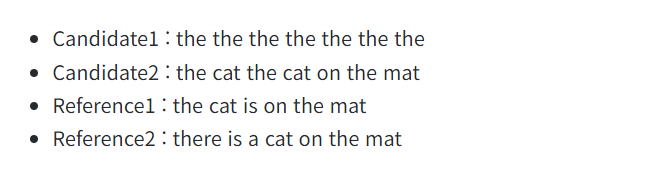

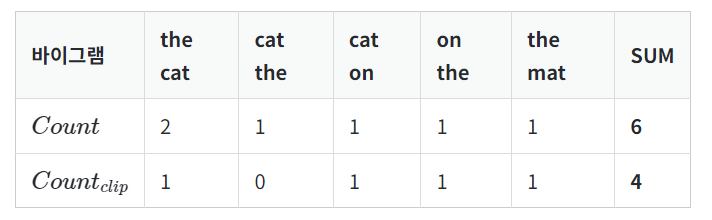

Candidate 1의 precision은 0, Candidate 2의 precision은 4/6이 딘다.

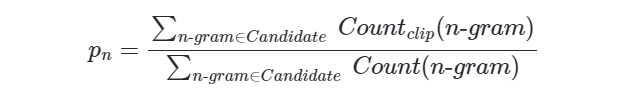

이를 토대로, BLEU score의 공식 이해

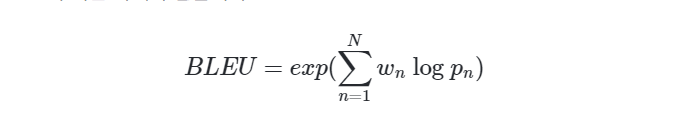

여기서 N은 n-gram에서 n의 최대값이다. N=4라면, unigram, bi-gram, tri-gram, quad-gram을 모두 고려한다는 것이다.

w_n은 각 gram의 보정된 정밀도에 대한 가중치이다. 이 가중치의 합은 1이 되게 한다. 이를 통해 어떤 n-gram을 중요시할 지 정할 수 있다.

#BLEU Score에 대한 문제점

번역 결과의 길이가 매우 짧다면, BLEU score는 이점이 없다.

Candidate: It is

Reference: It is a cat

이 때, Candidate의 precision은 1-gram과 2-gram에서 모두 1을 보인다.
따라서, Candidate가 Reference보다 문장의 길이가 짧은 경우에는 점수에 패널티를 주어야 할 필요가 있다. 이를 **Brevity Penalty**라고 한다.

#최종 BLEU Score 공식

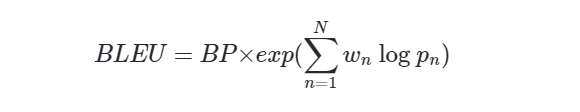

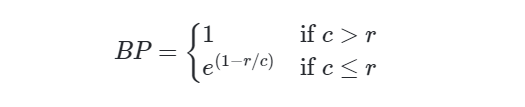

이때, c는 Candidate 길이, r는 Candidate와 길이 차이가 가장 작은 Reference의 길

In [7]:
def closest_ref_length(candidate, reference_list):
  ca_len = len(candidate)
  ref_lens = (len(ref) for ref in reference_list)
  closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len-ca_len), ref_len))
  return closest_ref_len

In [2]:
def brevity_penalty(candidate, reference_list):
  ca_len = len(candidate)
  ref_len = closest_ref_length(candidate, reference_list)
  if(ca_len > ref_len):
    return 1
  elif ca_len == 0:
    return 0
  else:
    return np.exp(1-ref_len/ca_len)

In [3]:
def bleu_score(candidate, reference_list, weights = [0.25,0.25,0.25,0.25]):
  bp = brevity_penalty(candidate, reference_list)
  p_n = [modified_precision(candidate, reference_list, n=n) for n, _ in enumerate(weights, start=1)]
  score = np.sum([w_i * np.log(p_i) if p_i !=0 else 0 for w_i, p_i in zip(weights, p_n)])
  return bp*np.exp(score)

In [18]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('실습 코드의 BLEU :',bleu_score(candidate.split(),list(map(lambda ref: ref.split(), references))))
print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))


실습 코드의 BLEU : 0.5045666840058485
패키지 NLTK의 BLEU : 0.5045666840058485
